In [361]:
%matplotlib notebook

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1462, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [3]:
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it

from functools import partial
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

sns.set_style('darkgrid')

# Generate some data

In [11]:
n_mixture = 2
lambdas = np.random.randint(1, 19, size=2)
lambdas

array([14,  3])

In [12]:
data = ss.expon.rvs(lambdas, size=(5, 2)).ravel()
data

array([14.31199476,  3.15674271, 14.78365063,  3.18348501, 15.70177289,
        3.04538708, 15.78110756,  3.15189418, 15.14211402,  3.48149751])

In [101]:
k = np.array([0, 1, 0, 1])
lambdas[k]

array([14,  3, 14,  3])

In [102]:
x_samples = np.logspace(0, 3, 100)
y_samples = ss.expon(scale=lambdas).pdf(x_samples.reshape(-1,1))

lines = plt.plot(x_samples, y_samples, label=('a','b'))
lines[0].set_label("a")
lines[1].set_label("b")

plt.semilogx()
plt.legend()

Or just use the data points from the lecture

In [177]:
x = np.array([0.64, 0.016, 0.100, 0.050, 3.09, 2.14, 0.200, 7.10])

# Likelihood functions

In [178]:
def likelihood(x, k, lambdas):
    return (np.exp(-x.reshape(1,-1)/lambdas[k]) / lambdas[k]).prod()

def log_likelihood(x, k, lambdas):
    return (-x.reshape(1,-1)/lambdas[k] - np.log(lambdas[k])).sum()

In [179]:
def likelihood_simple(x, lambd):
    return (np.exp(-x.reshape(1,-1)/lambd.reshape(-1, 1)) / lambd.reshape(-1, 1)).prod(axis=1)

In [284]:
simple_like = likelihood_simple(x, lamds)

In [230]:
all_likelihoods = simple_like

arg_max = all_likelihoods.argmax()
best_lambda = lamds[arg_max]

1.6297508346206444

<IPython.core.display.Javascript object>


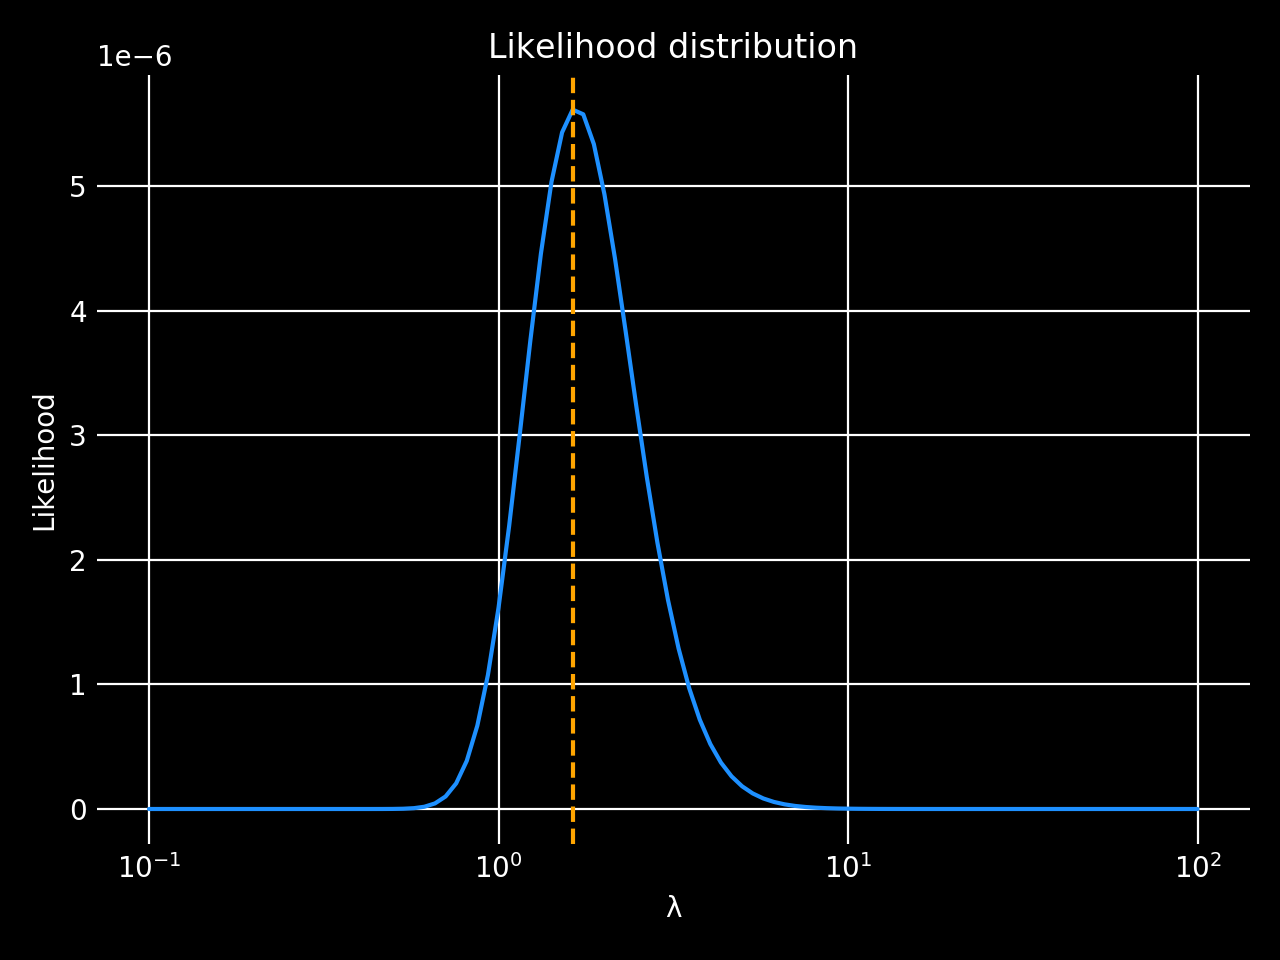

In [456]:
lamds = np.logspace(-1, 2, 100)

with plt.style.context(('dark_background')):
    f, ax = plt.subplots()
    ax.plot(lamds, simple_like, color='dodgerblue')
    ax.set_title("Likelihood distribution")
    ax.semilogx()
    ax.axvline(x=best_lambda, ls="--", color='orange')
    ax.set_xlabel("λ")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1)) 
    ax.set_ylabel("Likelihood")

    plt.tight_layout()

In [461]:
evidence1 = all_likelihoods.mean()
ML_model1 = all_likelihoods.max()

In [462]:
evidence1, ML_model1

(7.219782145272832e-07, 5.61391024799127e-06)

## Make pancake

In [184]:
def make_pancake(x, k, loglam1_lim = (-2.5, 2.5), loglam2_lim = (-2.5, 2.5), n_points = 100):
    
    lam1 = np.logspace(*loglam1_lim, n_points)
    lam2 = np.logspace(*loglam2_lim, n_points)
  
    lams = np.stack(np.meshgrid(lam1, lam2))
    lams_r = lams.reshape(2, -1).T
    
    partial_like = partial(log_likelihood, x, k)
    
    # faster than apply_along_axis!
    Z = np.array([log_likelihood(x, k, l) for l in lams_r])
    Z2 = np.exp(Z.reshape(lams.shape[1], lams.shape[2]))
    
    return lams[0], lams[1], Z2

In [452]:
def plot_pancake(X, Y, Z, ax=None, logx = True, logy = True, logz = False, title = None):
    
    if ax == None:
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    x_label = "Lambda 1"
    y_label = "Lambda 2"
    
    if title == None:
        title = r"Likelihood: $P(x | \lambda_1, \lambda_2, k)$"
    
    if logx:
        X = np.log(X)
        x_label = "Log " + x_label
    if logy:
        Y = np.log(Y)
        y_label = "Log " + y_label
    if logz:
        Z = np.log(Z)
        title = "Log " + title
        
    ax.set_title(title, color='firebrick')
    
    ax.ticklabel_format(axis='z', style='sci', scilimits=(0,1))
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, linewidth=1, antialiased=True,  
                           edgecolor='yellow',color='k')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return ax

<IPython.core.display.Javascript object>


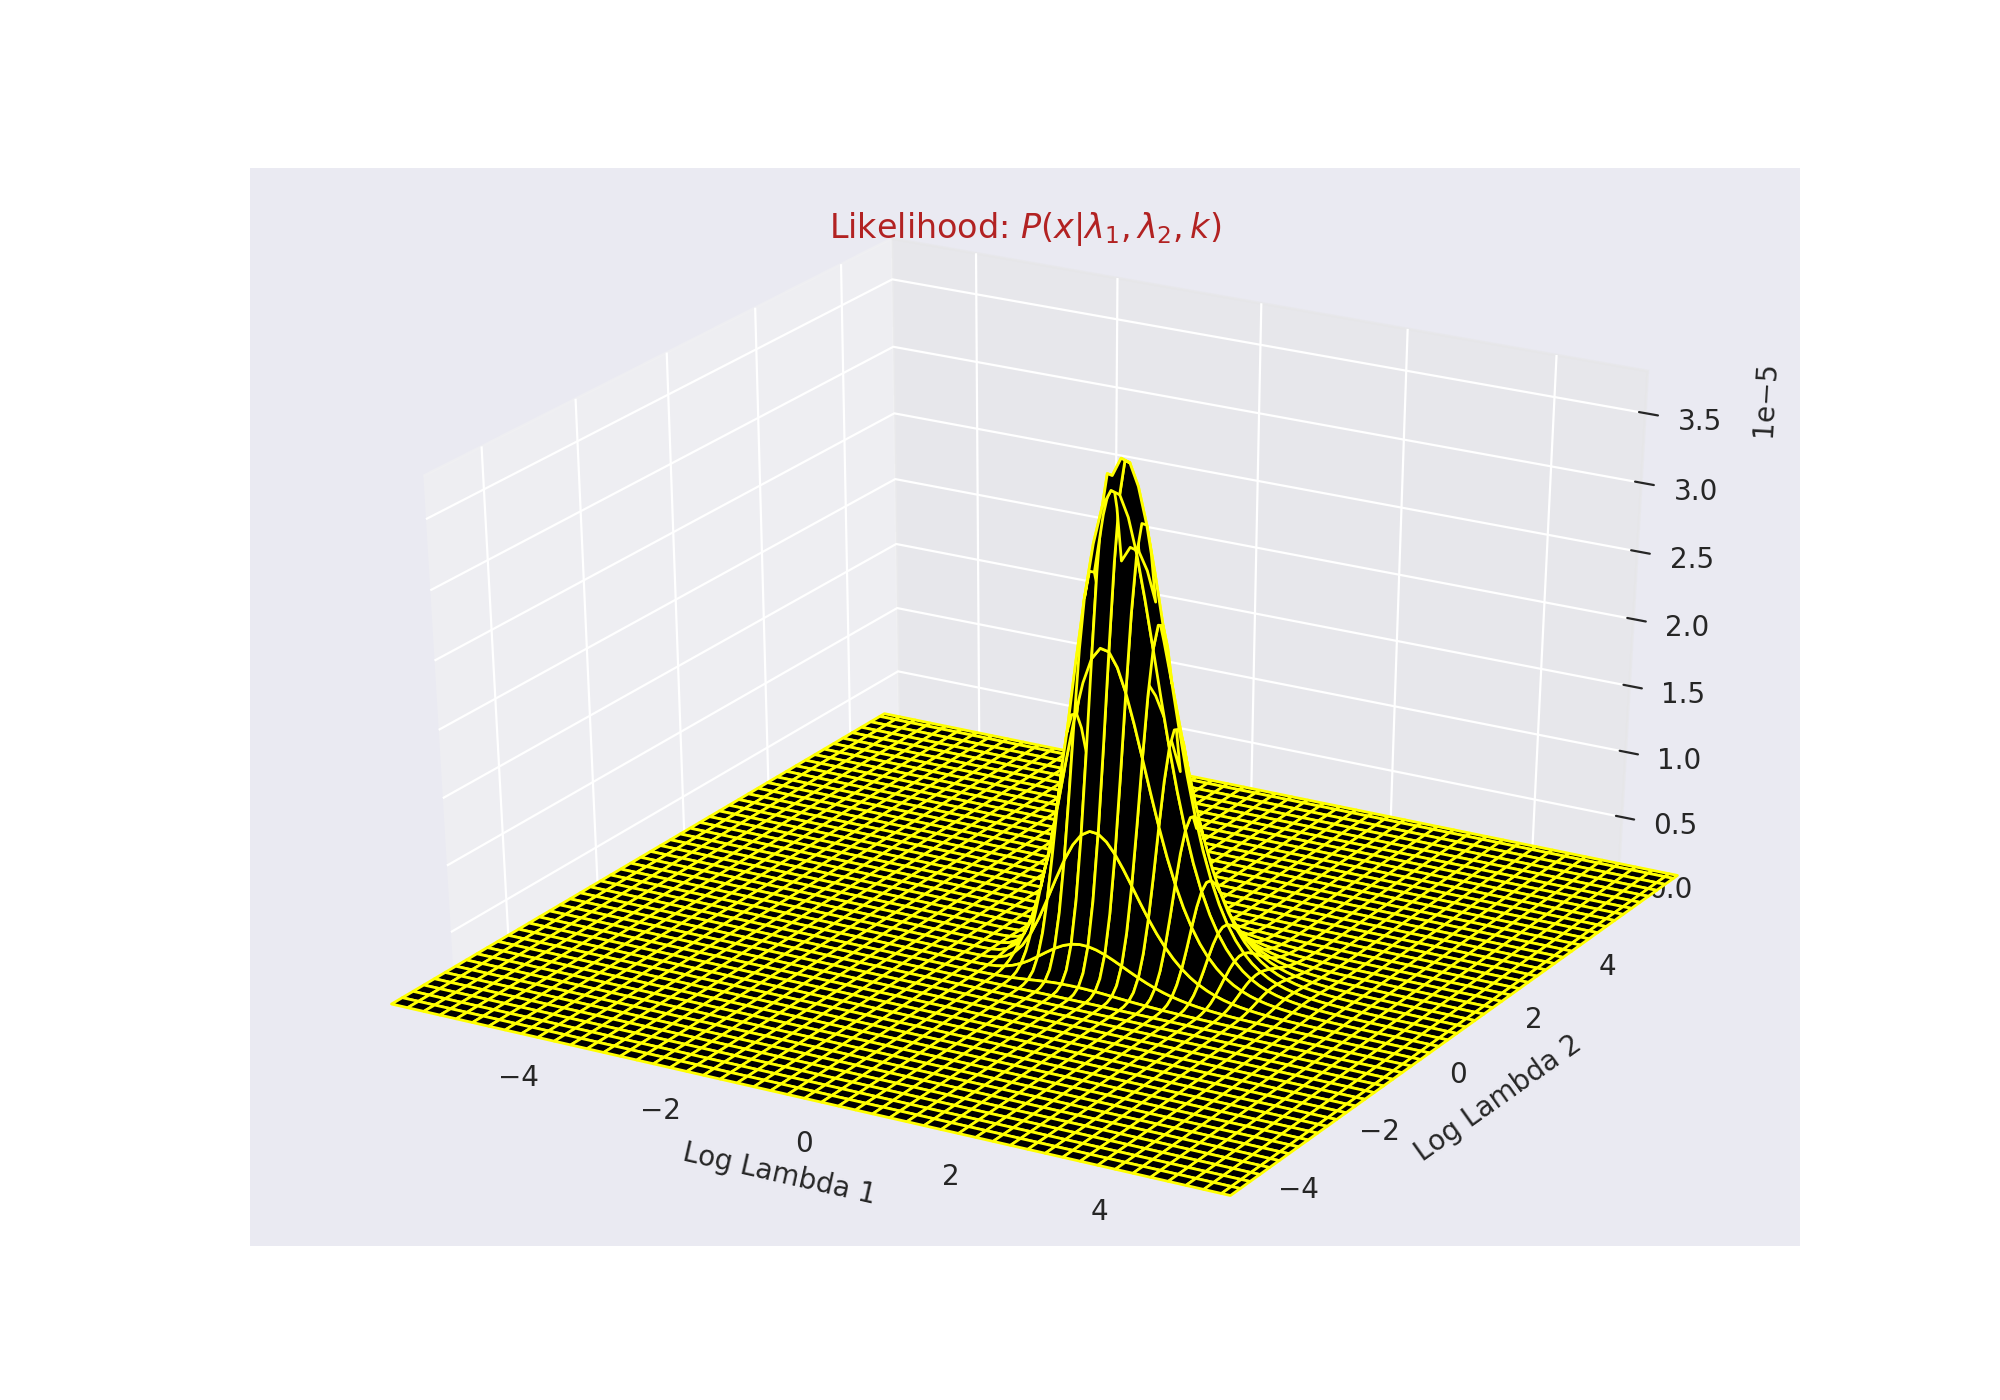

In [453]:
k = np.array([1, 1, 1, 1, 1, 0, 0, 0])

X, Y, Z = make_pancake(x, k)
plot_pancake(X, Y, Z);

# Stack pancakes

In [202]:
n_points = 100

all_ks = np.array(list(it.product([0, 1], repeat=x.shape[0])))

sum_Z = np.zeros((n_points, n_points))
all_Z = np.empty((all_ks.shape[0], *sum_Z.shape))

best_Z = 0

for i, k in enumerate(all_ks):
    if Z.sum() > best_Z:
        best_Z = Z.sum()
        best_k = k
    X, Y, Z = make_pancake(x, k, n_points=100)
    all_Z[i] = Z

In [203]:
best_k

array([1, 0, 0, 0, 1, 1, 1, 0])

In [444]:
def update_plot(frame_number, zarray, plot, ax):
    new_Z = zarray[frame_number, :,:]

    new_fig = ax.plot_surface(np.log(X), np.log(Y), zarray[frame_number, :,:],
                             linewidth=1, antialiased=True,  
                             edgecolor='yellow',color='k')

    x_label = "Log Lambda 1"
    y_label = "Log Lambda 2"

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.xaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    ax.yaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))

    ax.ticklabel_format(axis='z', style='sci', scilimits=(0,1))

    plot[0].remove()
    title.set_text("K: [{}]".format(' '.join(all_ks[frame_number].astype('str'))))
    ax.set_zlim(0, new_Z.max() * 1.1)
    plot[0] = new_fig
    

<IPython.core.display.Javascript object>


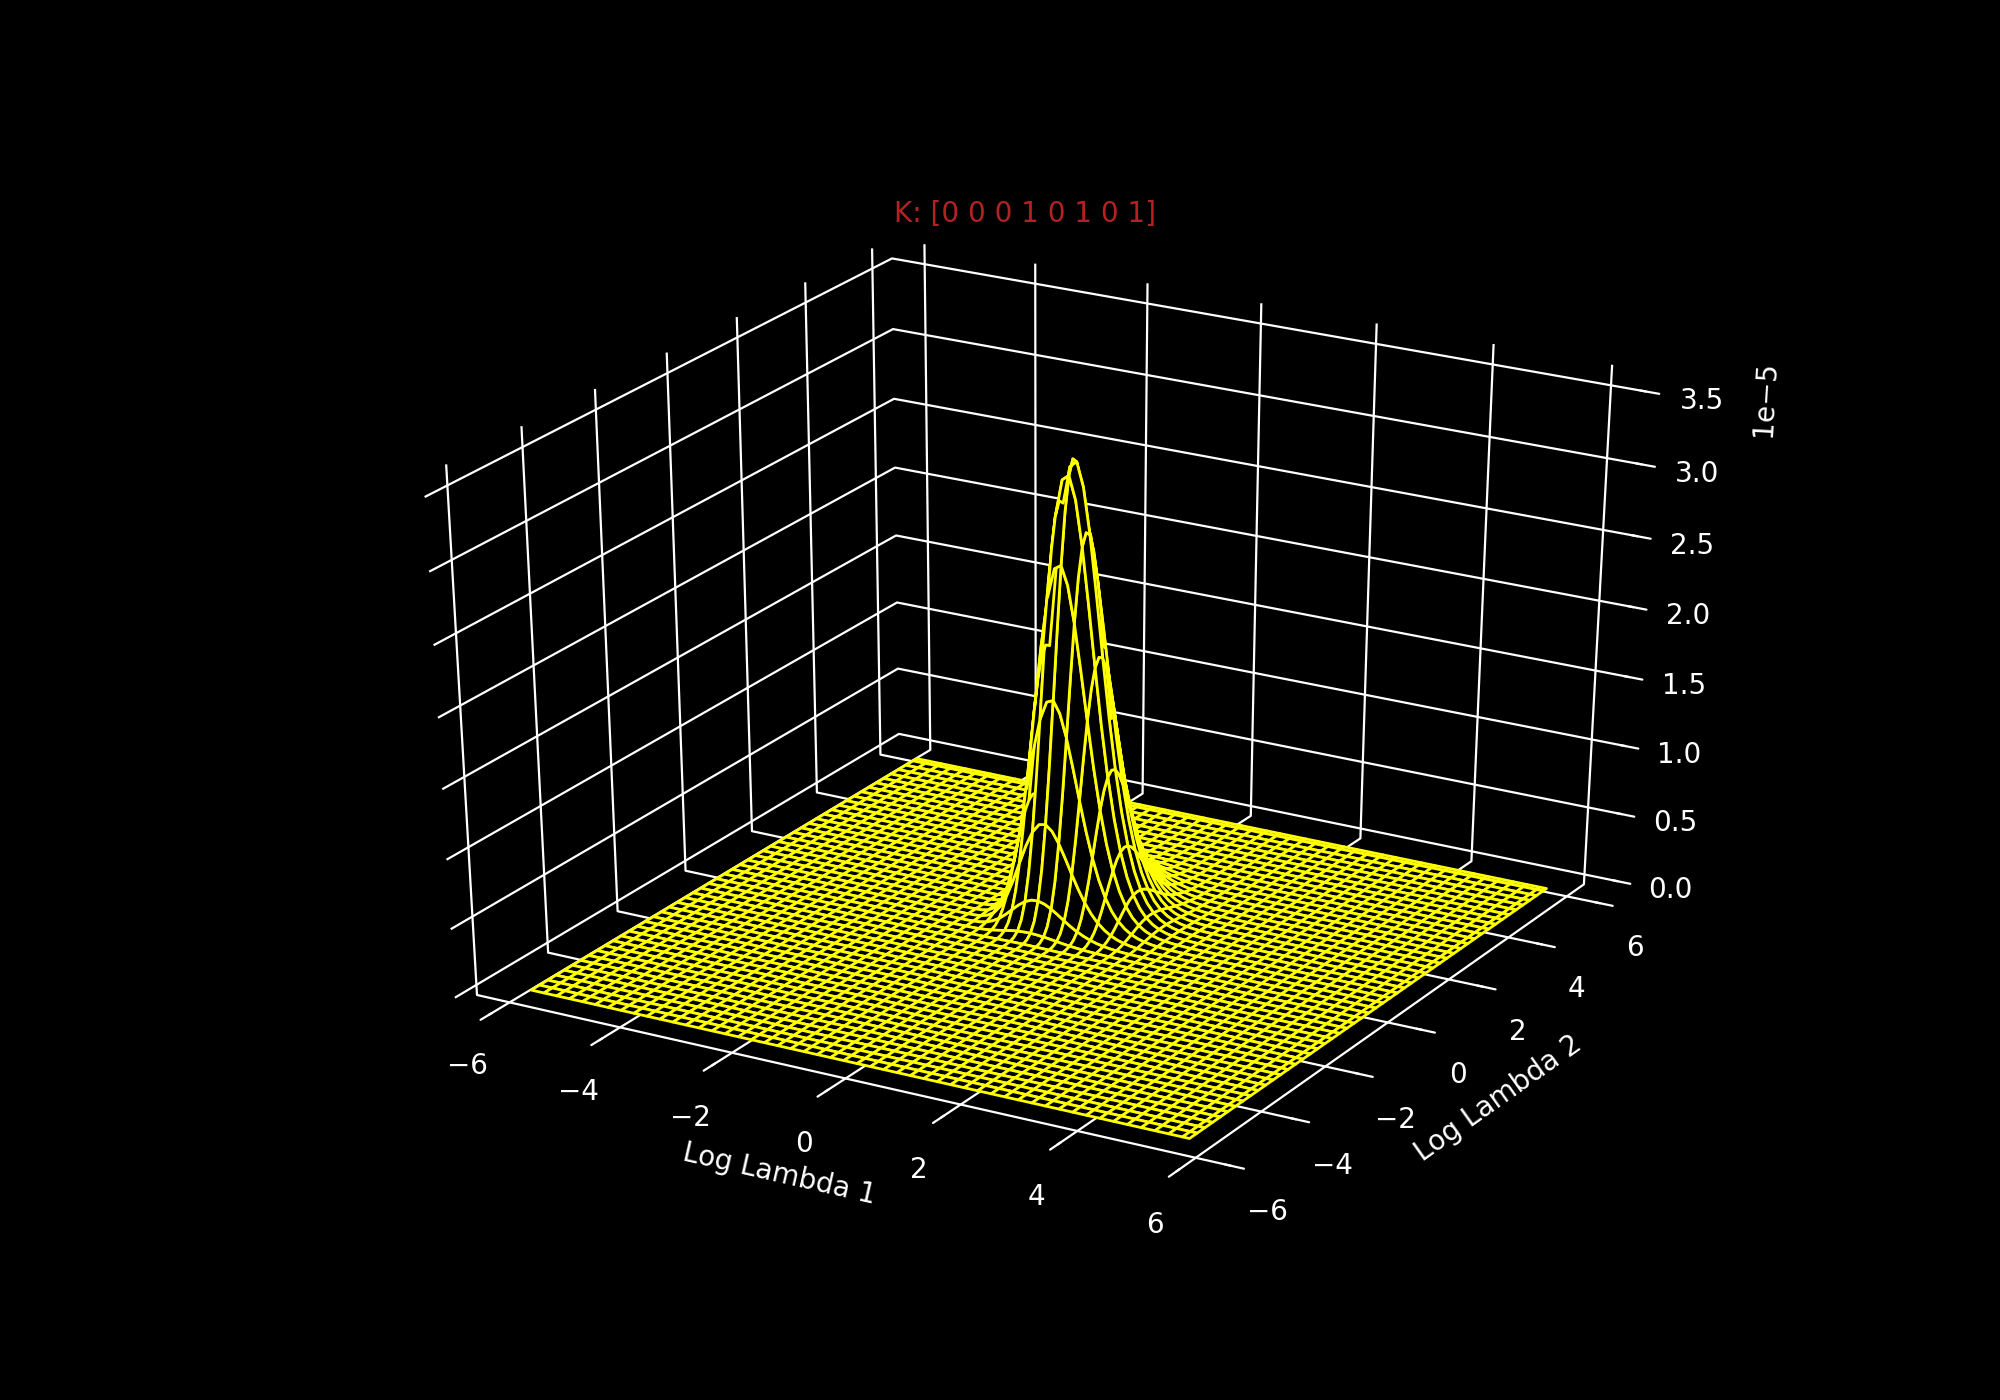

In [449]:

# Plot the surface.
with plt.style.context(('dark_background')):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')

    frames = all_ks.shape[0]

    init_fig = ax.plot_surface(np.zeros_like(X), np.zeros_like(Y), np.zeros_like(Z), linewidth=1, antialiased=True,  
                           edgecolor='yellow',color='k')
    title = ax.text2D(0.5, 0.95, s= "", ha="center", transform=ax.transAxes, color='firebrick')             
    ax.xaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    ax.yaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    ax.zaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    
surf = [init_fig]

ani = FuncAnimation(fig, update_plot, range(0, frames), fargs=(all_Z, surf, ax), interval=1000/20)

In [466]:
from matplotlib.animation import writers
writers.reset_available_writers()

In [470]:
ani.save('test.gif', dpi=80, writer='imagemagick', fps=5)

In [474]:
all_Z.mean(axis=0)/all_Z.sum()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.06171072e-21, 2.25824915e-21, 1.00704291e-21],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.18614342e-21, 3.67089060e-21, 1.64630760e-21],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.39005345e-20, 6.33560256e-21, 2.89215656e-21],
       ...,
       [5.06171072e-21, 8.18614342e-21, 1.39005345e-20, ...,
        2.54319599e-21, 1.62339902e-21, 1.06390482e-21],
       [2.25824915e-21, 3.67089060e-21, 6.33560256e-21, ...,
        1.62339902e-21, 1.00896633e-21, 6.43859036e-22],
       [1.00704291e-21, 1.64630760e-21, 2.89215656e-21, ...,
        1.06390482e-21, 6.43859036e-22, 4.00032212e-22]])

Let's stack (sum) all the pancakes and see what we get.

<IPython.core.display.Javascript object>


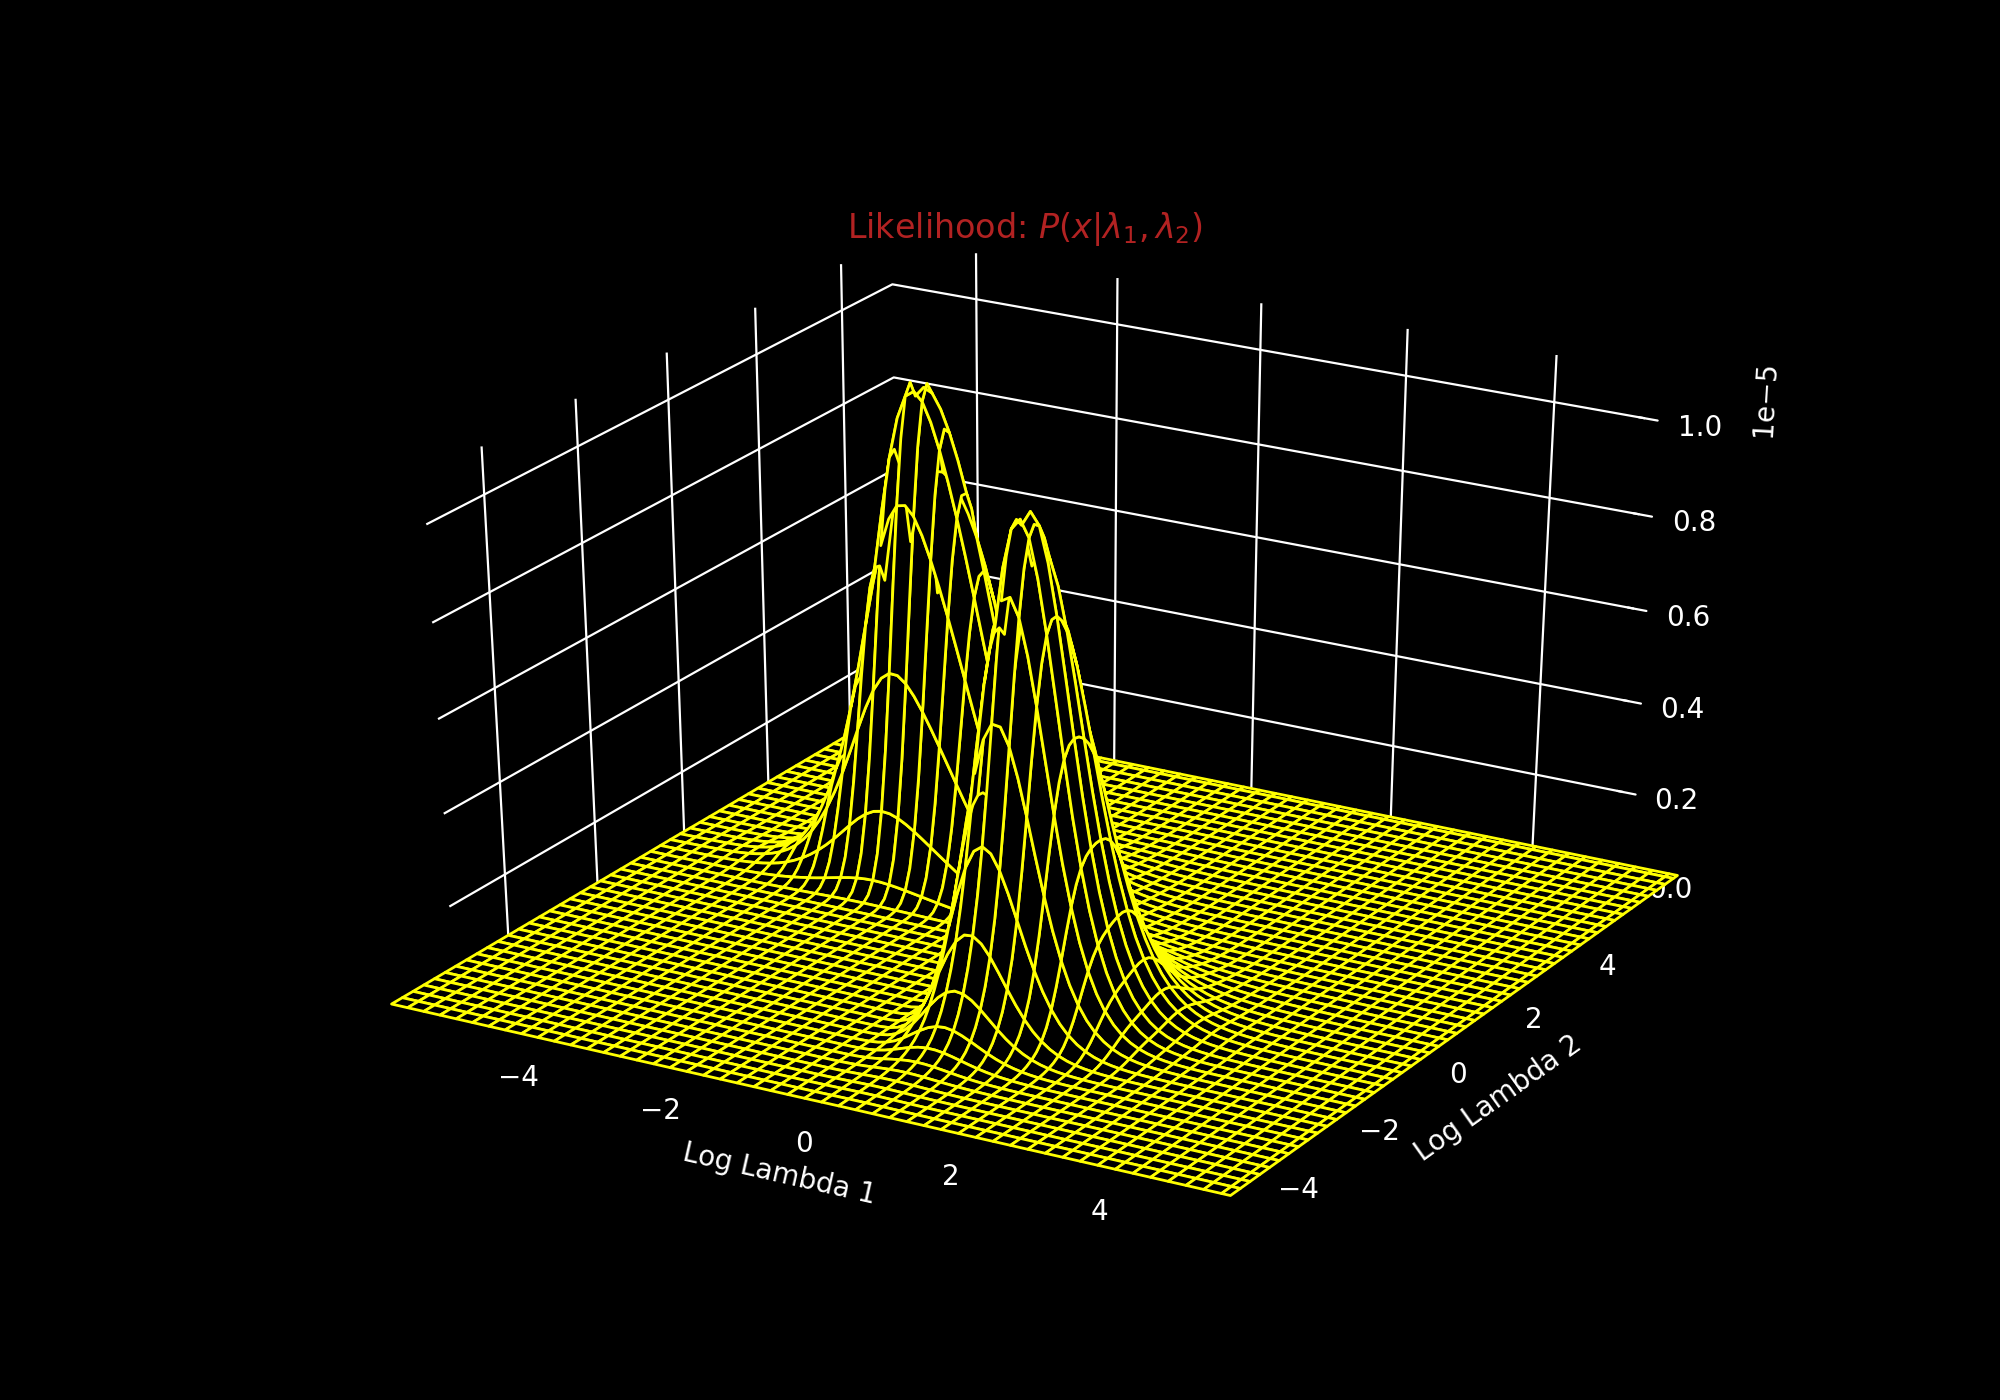

In [475]:
with plt.style.context(('dark_background')):
    ax = plot_pancake(X, Y, all_Z.mean(axis=0)/all_Z.sum(), title=r"Likelihood: $P(x | \lambda_1, \lambda_2)$");
    ax.xaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    ax.yaxis.pane.set_color((0.0, 0.0, 0.0, 0.0))
    

Looks like two clear peaks suggesting that there does indeed seem to be a mixture of two exponentials. 

# Statistics

For each of the 'k' vectors, what is the value of lambda with the greatest likelihood.

In [216]:
posterior_labels = all_Z.max(axis=1).max(axis=1)

<IPython.core.display.Javascript object>


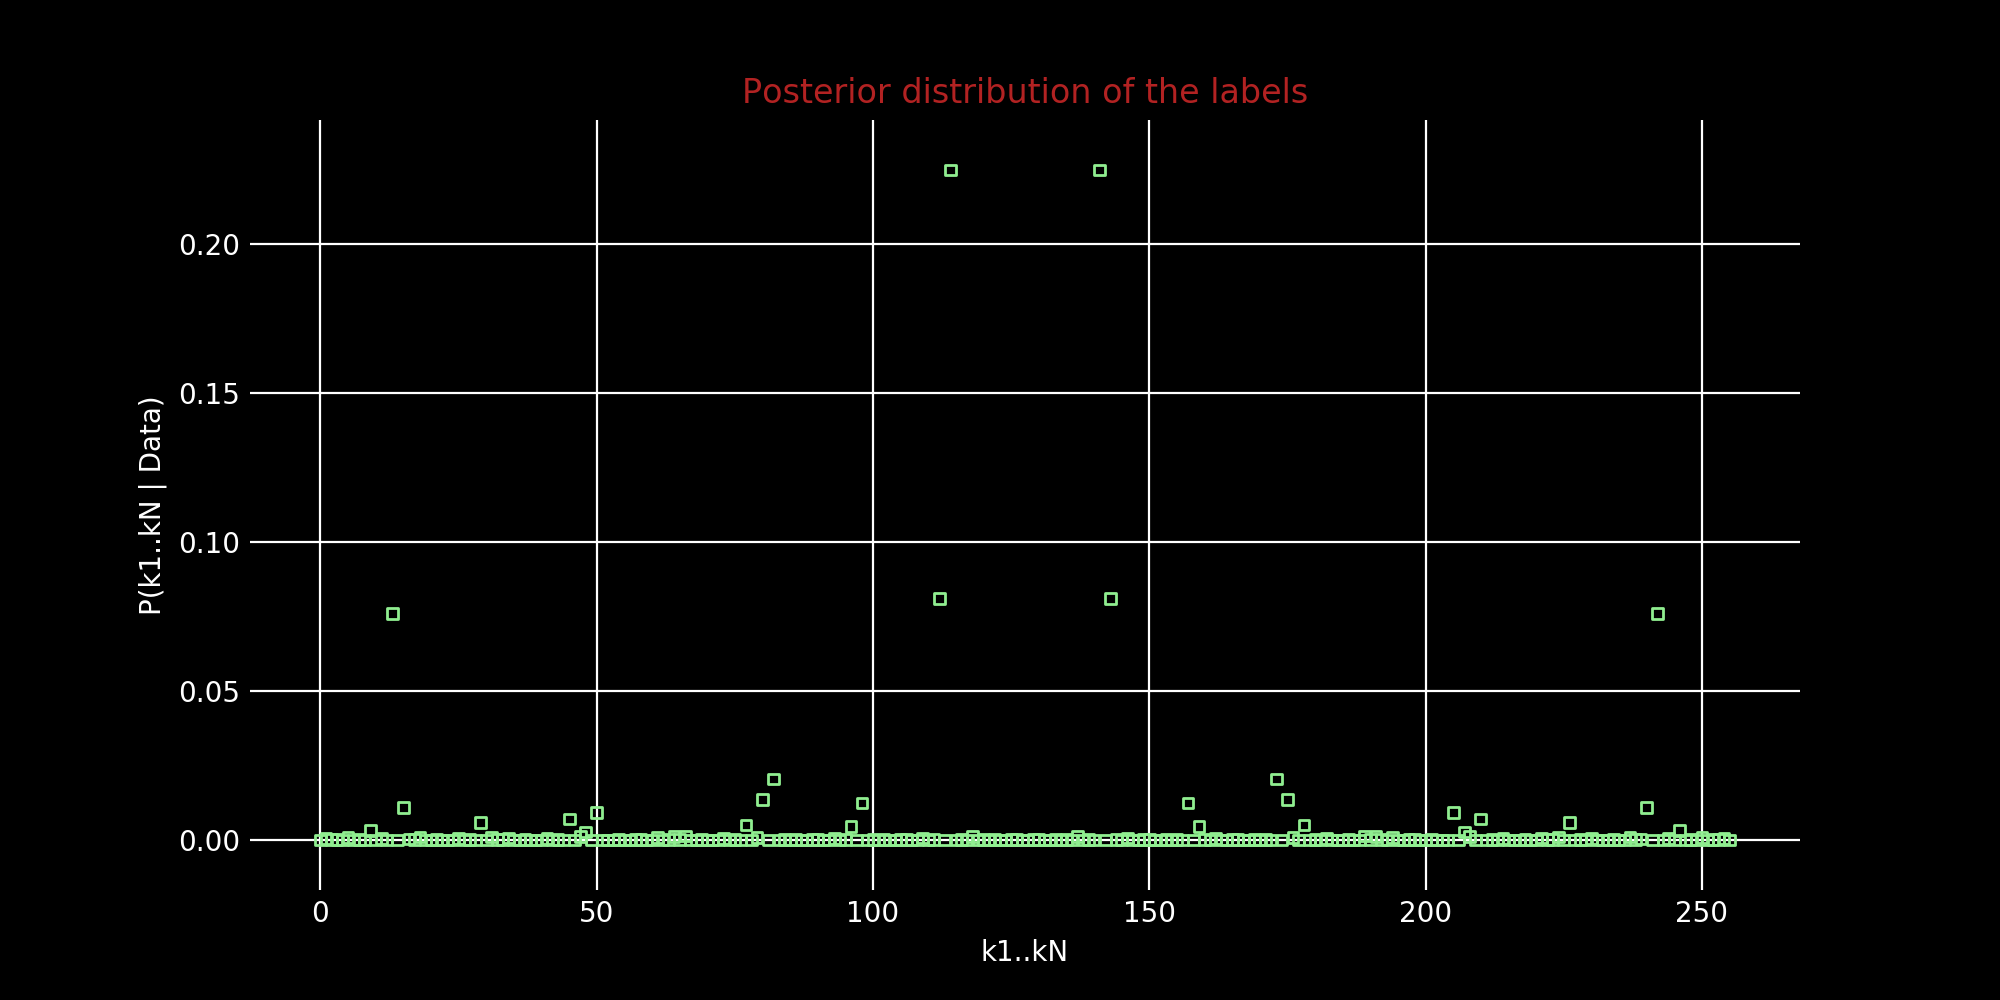

In [427]:
with plt.style.context(('dark_background')):
    f, ax= plt.subplots(figsize=(10,5))
    ax.scatter(np.arange(posterior_labels.shape[0]), posterior_labels / posterior_labels.sum(), facecolors='none', 
               edgecolors='lightgreen', marker='s', s=15)
    ax.set_xlabel("k1..kN")
    ax.set_ylabel("P(k1..kN | Data)")
    ax.set_title("Posterior distribution of the labels", color='firebrick');


Note the symmetry. Leave it up to the reader to figure out why.

There does exist some 'k' vector for which the likelihood is maximized. What are the lamdbas for it?

### Point estimate for lambdas

In [207]:
a = all_Z.sum(axis=0)
max_idx = np.unravel_index(a.argmax(), a.shape)

In [209]:
lam1 = X[max_idx]
lam2 = Y[max_idx]

lam1, lam2

(3.0185472600499215, 0.09218207178777464)

So the two lambdas are 3.02, 0.09

### Best labels

In [220]:
best_labels_idx = posterior_labels.argmax()
all_ks[best_labels_idx]

array([0, 1, 1, 1, 0, 0, 1, 0])

In [476]:
best_labels_idx

114

In [482]:
np.argwhere(posterior_labels == posterior_labels.max())

array([[114],
       [141]])

### Evidence

In [483]:
evidence2 = all_Z.mean()
evidence2

9.361597092624676e-06

In [484]:
EvidenceRatio = evidence2 / evidence1
EvidenceRatio

12.966592210478542

The evidence $p(x|H_2)$ is 9.36e-06

### Model comparison (Bayes Factor)

$$
p(H_1 \vert x) = \frac{p (x | H_1) * p (H_1)}{p (x | H_1) *  p (H_1)  + p (x | H_2) *  p (H_2)}
$$

$$
p(H_1) = p(H_2) = 0.5
$$

In [263]:
PosteriorProbOfH2 = evidence2  / (evidence1 + evidence2)
PosteriorProbOfH1 = evidence1  / (evidence1 + evidence2)

In [280]:
PosteriorProbOfH2, PosteriorProbOfH1

(0.928400572957966, 0.07159942704203409)